reference tutorial: 
https://github.com/lhe17/nebula

In [1]:
library('Seurat')
library('dplyr')
library("tidyverse")
library('RColorBrewer')
library('ggplot2')
library('data.table')
library(Matrix.utils)
library(Matrix)
library(tibble)
library(SingleCellExperiment)
library(pheatmap)
library(nebula)
library(stats)


Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Registered S3 method overwritten by 'cli':
  method     from         
  print.boxx spatstat.geom

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.3     ✔ stringr 1.4.0
✔ tidyr   1.1.3     ✔ forcats 0.5.1
✔ readr   1.4.0     

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following object is masked from ‘package:purrr’:

    transpose


The following objects are masked from ‘package:dplyr’:

    between, first, last


Loading required packa

# Load single cell object

In [2]:
subtyped <-readRDS("/net/bmc-lab5/data/kellis/group/Fu_Doris/Nebula/takeda_ICI_DBscan_Immune_subtyped092321.rds")

In [3]:
names(subtyped@meta.data)

[1] "sample_ID"             "cell_barcode"          "nCount_RNA"           
 [4] "percent_ribo"          "percent_heme"          "nFeature_RNA"         
 [7] "scRNA_name"            "patient"               "age"                  
[10] "sex"                   "subtype"               "treatment_group"      
[13] "state"                 "response_short"        "tissue"               
[16] "pfs"                   "percent_mt"            "nCount_SCT"           
[19] "nFeature_SCT"          "S.Score"               "G2M.Score"            
[22] "Phase"                 "transfer.cell.type"    "SCT_snn_res.1.2"      
[25] "seurat_clusters"       "SCT_snn_res.0.8"       "SCT_snn_res.0.6"      
[28] "SCT_snn_res.0.4"       "DBscan"                "general.cell.type"    
[31] "SCT_snn_res.0.2"       "SCT_snn_res.0.7"       "Dbscan"               
[34] "reannotated.cell.type"

In [4]:
unique(subtyped@meta.data$reannotated.cell.type)

[1] "T Cycling"   "Plasma B"    "NK"          "Macrophage"  "B"          
 [6] "CD8 Exhau"   "CD8 Cyto"    "CD4 Treg"    "CD4 Naive"   "GC B"       
[11] "Erythrocyte" "CD4 Activ"

# Subset a cluster of cells 

In [5]:
clust<- "Macrophage"

In [11]:
cluster <- subset(subtyped, subset = (reannotated.cell.type == clust) 
                  & (response_short == 'PD'))

In [12]:
cluster <- subset(cluster, subset = (state == 'PRE') | (state == 'ON'))

In [13]:
cluster@meta.data %>% group_by(state, scRNA_name) %>% summarise(cells = n(), 
                                                        )

`summarise()` has grouped output by 'state'. You can override using the `.groups` argument.



state,scRNA_name,cells
<chr>,<chr>,<int>
ON,1037_post,921
ON,1087_on,550
ON,1224_on1,44
ON,776_on,164
ON,926_on,323
PRE,406_pre,468
PRE,620_pre,730
PRE,854_pre,581
PRE,856_A_pre,592


In [16]:
cluster <- subset(cluster, subset = ( scRNA_name != '880_pre'  & scRNA_name != '1087_on' & scRNA_name != '1224_on1'))

In [17]:
unique(cluster@meta.data$tissue)

[1] "skin"  "liver"

## Extract matrix

In [18]:
count_mtx <-GetAssayData(object = cluster, slot = "counts")
col_data <- cluster@meta.data[c("age", "sex", "patient", "tissue","treatment_group","state",
                                "percent_mt","percent_ribo" )]

In [20]:
col_data$age <- as.numeric(col_data$age)
col_data$condition <- as.integer(col_data$state == 'ON')

In [21]:
head(col_data)

,age,sex,patient,tissue,treatment_group,state,percent_mt,percent_ribo,condition
,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>
11808_CELL_75,62,M,926,skin,ICI_PD1,ON,3.176956,0.1308377,1
11808_CELL_97,62,M,926,skin,ICI_PD1,ON,1.742160,0.1838822,1
11808_CELL_111,62,M,926,skin,ICI_PD1,ON,3.509180,0.1209040,1
11808_CELL_119,62,M,926,skin,ICI_PD1,ON,2.664878,0.1633915,1
11808_CELL_127,62,M,926,skin,ICI_PD1,ON,1.748563,0.1613324,1
11808_CELL_135,62,M,926,skin,ICI_PD1,ON,4.188762,0.1039743,1


In [22]:
sample_id <- cluster@meta.data$scRNA_name

In [23]:
unique(sample_id)

[1] "926_on"    "406_pre"   "620_pre"   "1037_post" "854_pre"   "776_on"   
[7] "856_A_pre" "856_B_pre"

## Calculate offset


In [24]:
nFeature_RNA <-  cluster@meta.data$nFeature_RNA


## Remove low variance genes

In [26]:
pre_cells <- rownames(col_data[col_data['condition'] ==0, ])
on_cells <- rownames(col_data[col_data['condition'] ==1, ])

In [27]:
keep1 <- rowSums(count_mtx[,pre_cells] != 0) >= length(pre_cells)*0.20
keep2 <- rowSums(count_mtx[,on_cells] != 0) >= length(on_cells)*0.20


In [28]:
count_mtx <- count_mtx[keep1 & keep2,]
nrow(count_mtx)

[1] 510

## remove mitochondrial and ribosomal genes

In [29]:
## remove blacklisted genes
MALAT1 <- grepl("MALAT1", rownames(count_mtx))
count_mtx <- count_mtx[!MALAT1,] 

MTRNR2L12 <- grepl("MTRNR2L12", rownames(count_mtx))
count_mtx <- count_mtx[!MTRNR2L12,] 
nrow(count_mtx)

[1] 508

In [30]:
MT_genes <- grepl("MT-", rownames(count_mtx))
count_mtx <- count_mtx[!MT_genes,] 
nrow(count_mtx)

[1] 498

In [31]:
RPS_genes <- grepl("RPS", rownames(count_mtx))
count_mtx <- count_mtx[!RPS_genes,] 
nrow(count_mtx)

[1] 466

In [32]:
RPL_genes <- grepl("RPL", rownames(count_mtx))
count_mtx <- count_mtx[!RPL_genes,] 
nrow(count_mtx)

[1] 420

## build model

In [33]:
head(col_data)

,age,sex,patient,tissue,treatment_group,state,percent_mt,percent_ribo,condition
,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>
11808_CELL_75,62,M,926,skin,ICI_PD1,ON,3.176956,0.1308377,1
11808_CELL_97,62,M,926,skin,ICI_PD1,ON,1.742160,0.1838822,1
11808_CELL_111,62,M,926,skin,ICI_PD1,ON,3.509180,0.1209040,1
11808_CELL_119,62,M,926,skin,ICI_PD1,ON,2.664878,0.1633915,1
11808_CELL_127,62,M,926,skin,ICI_PD1,ON,1.748563,0.1613324,1
11808_CELL_135,62,M,926,skin,ICI_PD1,ON,4.188762,0.1039743,1


In [45]:
mm = model.matrix(~condition+tissue+age+treatment_group+percent_mt+sex, data=col_data)
head(mm)

,(Intercept),condition,tissueskin,age,treatment_groupICI_PD1,percent_mt,sexM
11808_CELL_75,1,1,1,62,1,3.176956,1
11808_CELL_97,1,1,1,62,1,1.742160,1
11808_CELL_111,1,1,1,62,1,3.509180,1
11808_CELL_119,1,1,1,62,1,2.664878,1
11808_CELL_127,1,1,1,62,1,1.748563,1
11808_CELL_135,1,1,1,62,1,4.188762,1


In [46]:
result = nebula(count_mtx,sample_id,pred=mm, offset =nFeature_RNA,  model="NBLMM")

Remove  0  genes having low expression.
Analyzing  420  genes with  8  subjects and  3983  cells.


In [47]:
result$convergence[result$convergence < -20]

numeric(0)

In [48]:
names(result)

[1] "summary"        "overdispersion" "convergence"    "algorithm"     
[5] "covariance"

In [49]:
names(result$summary)

[1] "logFC_(Intercept)"            "logFC_condition"             
 [3] "logFC_tissueskin"             "logFC_age"                   
 [5] "logFC_treatment_groupICI_PD1" "logFC_percent_mt"            
 [7] "logFC_sexM"                   "se_(Intercept)"              
 [9] "se_condition"                 "se_tissueskin"               
[11] "se_age"                       "se_treatment_groupICI_PD1"   
[13] "se_percent_mt"                "se_sexM"                     
[15] "p_(Intercept)"                "p_condition"                 
[17] "p_tissueskin"                 "p_age"                       
[19] "p_treatment_groupICI_PD1"     "p_percent_mt"                
[21] "p_sexM"                       "gene_id"                     
[23] "gene"

In [50]:
preOn_res <- result$summary[c('logFC_condition','se_condition','p_condition','gene')] %>% arrange(p_condition)

## further process result

In [51]:
preOn_res <- preOn_res[result$convergence > -20,]


In [52]:
preOn_res <- drop_na(preOn_res)

In [53]:
head(preOn_res,5)

,logFC_condition,se_condition,p_condition,gene
,<dbl>,<dbl>,<dbl>,<chr>
1,0.8481116,0.08444654,9.844995e-24,PNRC1
2,-1.1885199,0.12507618,2.051703e-21,CTSB
3,0.7576899,0.08096303,8.090188e-21,HNRNPA2B1
4,-1.6828953,0.18691280,2.183583e-19,APOC1
5,0.7899421,0.09433805,5.591945e-17,EIF4A2


In [56]:
preOn_res$BH<- p.adjust(preOn_res$p_condition, "BH")
preOn_res$bonferroni<- p.adjust(preOn_res$p_condition, "bonferroni")
preOn_res$holm<- p.adjust(preOn_res$p_condition, "holm")
preOn_res$BY<- p.adjust(preOn_res$p_condition, "BY")



In [57]:
head(preOn_res,20)

,logFC_condition,se_condition,p_condition,gene,BH,bonferroni,holm,BY
,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.8481116,0.08444654,9.844995e-24,PNRC1,4.134898e-21,4.134898e-21,4.134898e-21,2.736749e-20
2,-1.1885199,0.12507618,2.051703e-21,CTSB,4.308577e-19,8.617154e-19,8.596637e-19,2.851701e-18
3,0.7576899,0.08096303,8.090188e-21,HNRNPA2B1,1.132626e-18,3.397879e-18,3.381699e-18,7.496469e-18
4,-1.6828953,0.18691280,2.183583e-19,APOC1,2.292762e-17,9.171047e-17,9.105540e-17,1.517501e-16
5,0.7899421,0.09433805,5.591945e-17,EIF4A2,4.697234e-15,2.348617e-14,2.326249e-14,3.108940e-14
6,0.7152174,0.08963224,1.469686e-15,SAMHD1,1.028780e-13,6.172680e-13,6.099195e-13,6.809145e-13
7,0.6489767,0.08541558,3.010381e-14,SRSF7,1.806228e-12,1.264360e-11,1.246298e-11,1.195481e-11
8,-1.2040985,0.16635003,4.542025e-13,GLUL,2.384563e-11,1.907650e-10,1.875856e-10,1.578261e-10
9,-1.5767611,0.22293230,1.518111e-12,CTSD,7.084516e-11,6.376065e-10,6.254616e-10,4.689001e-10


# Select DEG

In [58]:
readr::write_csv(preOn_res, file=paste("/home/ruiwenfu/data-lab5/scRNA/ICI_all_results/pre_on_post/Nebula/",
                                      str_replace_all(clust, " ", "_"), "_OnPre_nebulaResult_adjustMTpercentage120321.csv", sep = "" ))


In [60]:
lfc.cutoff <- 0.58
padj.cutoff <- 0.01

# Visualize DEG  

## vocano plot

In [61]:
vocano_df <- preOn_res %>%
    mutate(log2FoldChange = logFC_condition, padj = BH) %>% column_to_rownames('gene')
    

#color DEG
vocano_df$diffexpressed <- "NO"
vocano_df$diffexpressed[vocano_df$log2FoldChange > lfc.cutoff & vocano_df$padj < padj.cutoff] <- "UP"
vocano_df$diffexpressed[vocano_df$log2FoldChange < -lfc.cutoff & vocano_df$padj < padj.cutoff] <- "DOWN"

vocano_df$delabel <- NA
vocano_df$delabel[vocano_df$diffexpressed != "NO"] <- rownames(vocano_df)[vocano_df$diffexpressed != "NO"]



Warning message:
“Removed 280 rows containing missing values (geom_text_repel).”
Warning message:
“ggrepel: 79 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


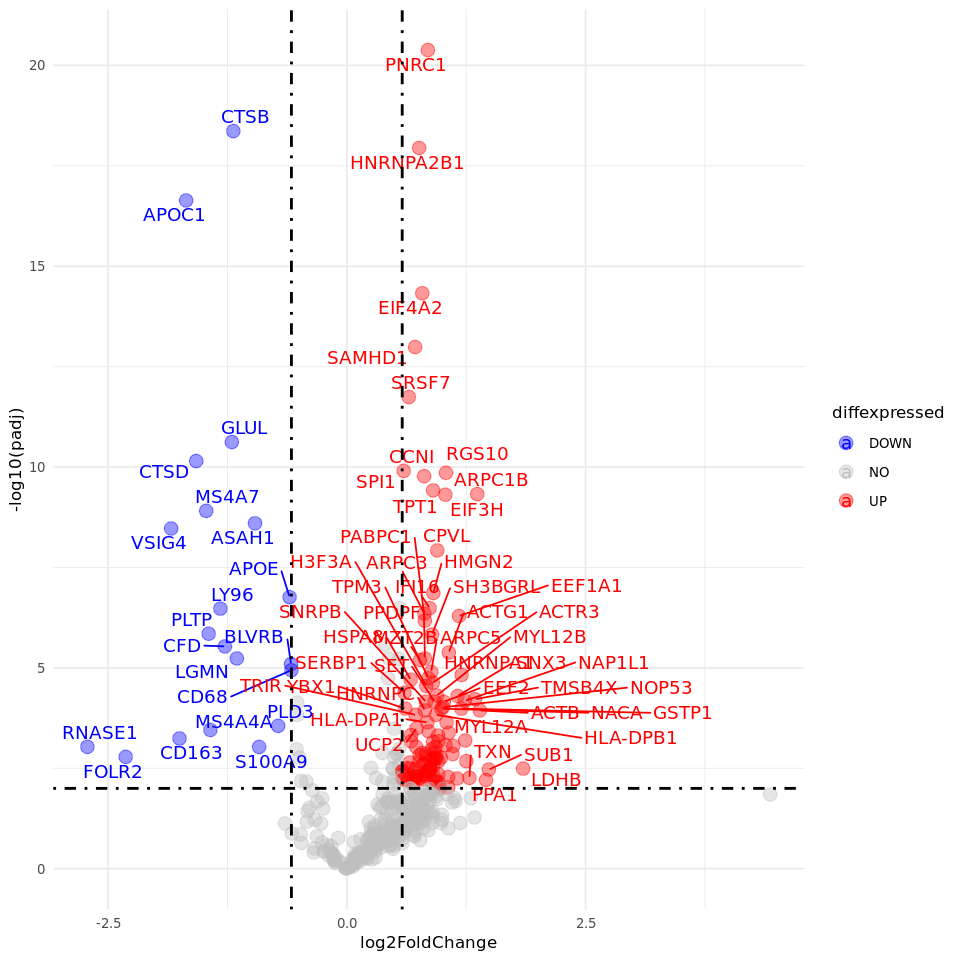

In [62]:
library(ggrepel)
options(repr.plot.width=8, repr.plot.height=8)

# plot adding up all layers we have seen so far
ggplot(data=vocano_df, aes(x=log2FoldChange, y=-log10(padj),col=diffexpressed, label=delabel)) +
        geom_point(alpha=0.4, size=3.5) +
        scale_color_manual(values=c("blue","grey","red"))+       
        theme_minimal() + 
        theme(text = element_text(size = 10)) +
        geom_text_repel(max.overlaps=40) +
        geom_vline(xintercept=c(-lfc.cutoff,lfc.cutoff),lty=4,col="black",lwd=0.8) +
        geom_hline(yintercept = -log10(padj.cutoff),lty=4,col="black",lwd=0.8) 

## violin plot

In [94]:
vln_df <- logcount_matx[head(preOn_res,20)$gene,]

ERROR: Error in as(x, "matrix")[i, , drop = drop]: subscript out of bounds


In [96]:
head(preOn_res,20)$gene

[1] "CACYBP"    "PSMB1"     "TRMT112"   "MTRNR2L12" "ZNF331"    "CCL4L2"   
 [7] "LAMTOR5"   "SRI"       "BTG2"      "LSM7"      "COX5A"     "JUNB"     
[13] "CCL5"      "CLTA"      "ENSA"      "PRDX6"     "HERPUD1"   "C19orf53" 
[19] "CHMP2A"    "ZFP36"

In [98]:
logcount_matx[]

ERROR: Error in as(x, "matrix")[i, , drop = drop]: subscript out of bounds


In [76]:
flat_dat$state <- factor(flat_dat$state, levels = c('PRE', 'ON'))

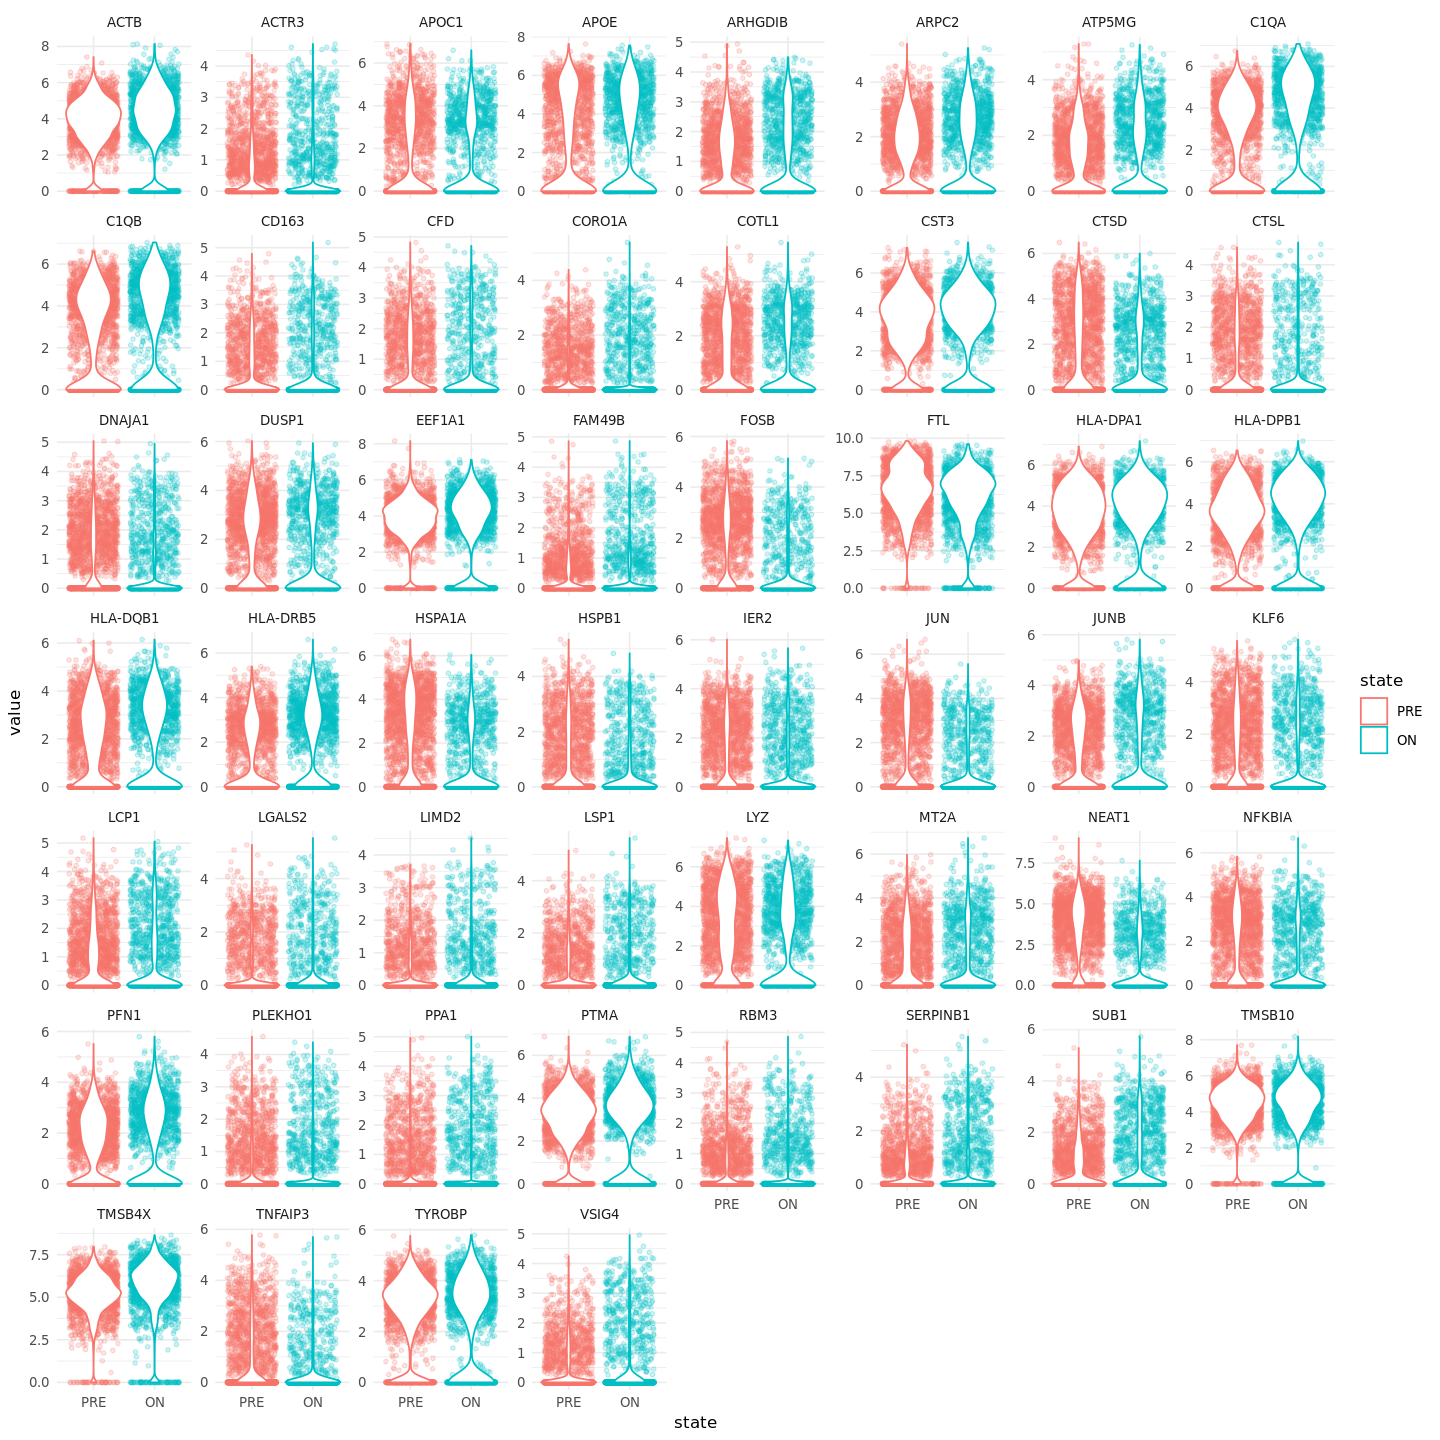

In [78]:
options(repr.plot.width=12, repr.plot.height=12)

ggplot(flat_dat, aes(x=state, y=value, color=state)) + 
    geom_jitter(size=1, alpha = 0.2) +
    theme_minimal(base_size = 10)+
    facet_wrap(~primerid, scale='free_y')+
    geom_violin()



In [80]:
fcHurdleSig[primerid=='C1QA',]

primerid,Pr(>Chisq),coef,ci.hi,ci.lo,fdr
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
C1QA,7.522847e-36,-1.369393,-0.765914,-1.972871,2.415686e-34


## Heatmap


In [63]:
topUp <- vocano_df %>% filter(diffexpressed == "UP") %>% 
    arrange(padj) %>% head(20)

topDown <- vocano_df %>% filter(diffexpressed == "DOWN") %>% 
    arrange(padj) %>% head(20)

sig_gene <- c(topUp$delabel, topDown$delabel)


In [64]:
### normalize counts by nFeature
count_adjust <- t(replicate(nrow(count_mtx), nFeature_RNA/mean(nFeature_RNA)))
count_adjusted_mtx <- count_mtx/count_adjust

### take log
logcount_matx <- log2(count_adjusted_mtx[sig_gene,]+1)

In [65]:
annot <- col_data %>% select(-c('condition', 'patient'))
annot$scRNA_name <- sample_id

In [66]:
col_order <- annot %>% arrange(match(state, c('PRE', 'ON')),tissue,scRNA_name)%>% rownames


In [67]:
nrow(filter(annot, state == 'PRE'))


[1] 2575

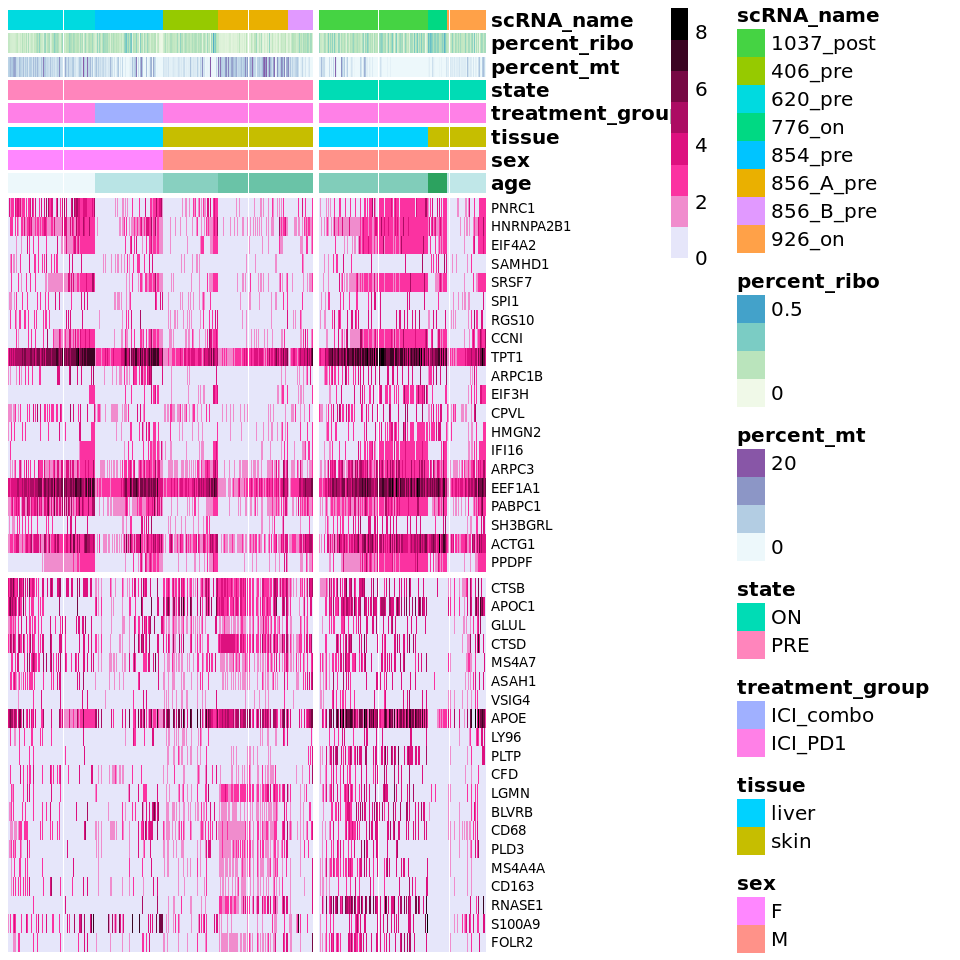

In [68]:
pheatmap(logcount_matx[sig_gene, col_order], 
     color = colorRampPalette(colors = c("lavender", "deeppink", "deeppink4", 'black'))(8), 
     cluster_rows = F,
     cluster_cols = F,
     show_rownames = T,
     show_colnames = F,
     annotation = annot[col_order,], 
     border_color = NA, 
     fontsize = 12, 
#      scale = "row", 
     fontsize_row = 8, 
     height = 6,
     width = 6,
     gaps_col = nrow(filter(annot, state == 'PRE')), 
     gaps_row = nrow(topUp)
    )
  


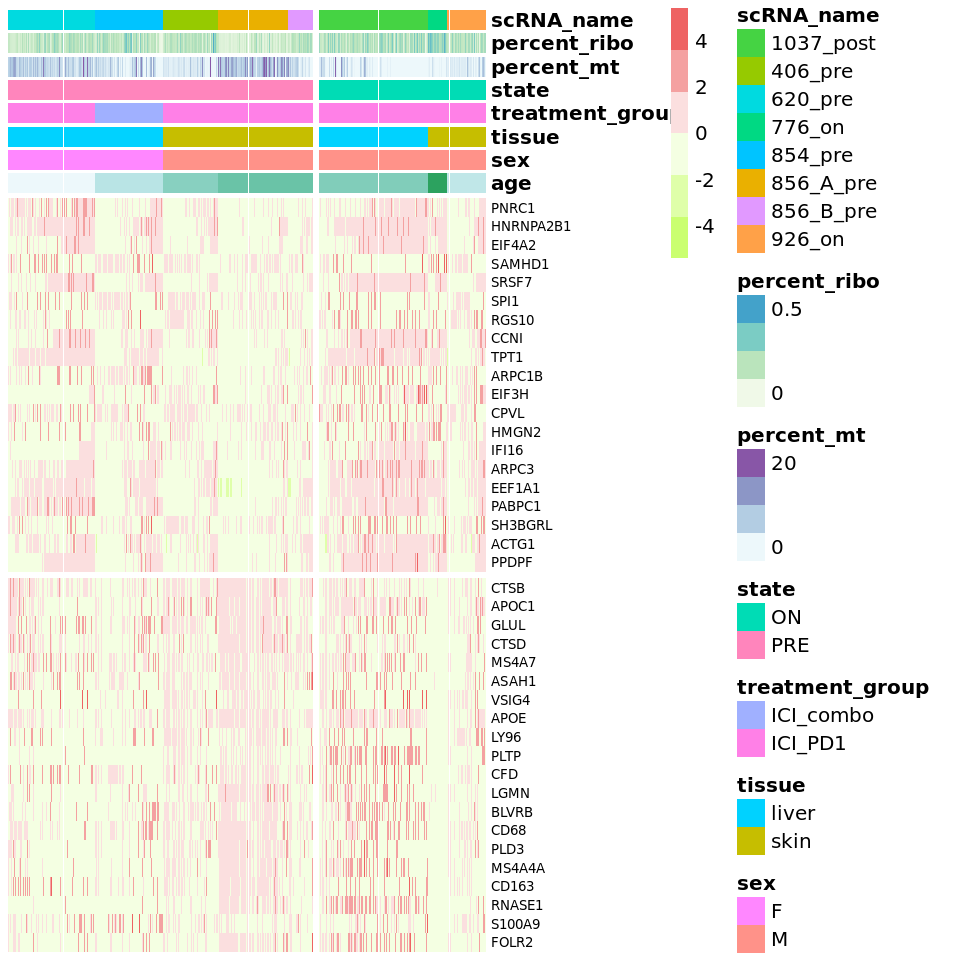

In [69]:
pheatmap(logcount_matx[sig_gene, col_order], 
     color = colorRampPalette(colors = c("darkolivegreen1", "white", "indianred2"))(6), 
     cluster_rows = F,
     cluster_cols = F,
     show_rownames = T,
     show_colnames = F,
     annotation = annot[col_order,], 
     border_color = NA, 
     fontsize = 12, 
     scale = "row", 
     fontsize_row = 8, 
     height = 6,
     width = 6,
     gaps_col = nrow(filter(annot, state == 'PRE')), 
     gaps_row = nrow(topUp)
    )
  

# GSEA

In [70]:
library(fgsea)
library(repr)

In [71]:
# Load the pathways into a named list
path = './../../data-lab5/011121_RNAseq/analysisReady'

pathways.hallmark <- gmtPathways(paste(path, 'GSEA/h.all.v7.1.symbols.gmt', sep = "/" ))
pathways.KEGG <- gmtPathways(paste(path, 'GSEA/c2.cp.kegg.v7.4.symbols.gmt', sep = "/" ))
pathways.GO <- gmtPathways(paste(path, 'GSEA/c5.go.v7.4.symbols.gmt', sep = "/" ))
pathways.Immune <- gmtPathways(paste(path, 'GSEA/c7.immunesigdb.v7.4.symbols.gmt', sep = "/" ))


In [77]:
sc_res2 <- vocano_df %>% 
    mutate(stat=log2FoldChange) %>%
    dplyr::select(stat) %>% rownames_to_column('row') %>% 
    drop_na()

sc_ranks <- deframe(sc_res2)


## Run GSEA

In [90]:
sc_fgseaRes <- fgsea(pathways=c(pathways.GO, pathways.hallmark, pathways.KEGG) , stats=sc_ranks)


In [91]:
#Tidy the results
sc_fgseaResTidy <- sc_fgseaRes %>%
  as_tibble() %>%
  arrange(padj)

In [93]:
sc_fgseaResTidy_ <- sc_fgseaResTidy
sc_fgseaResTidy_$leadingEdge <- as.character(sc_fgseaResTidy_$leadingEdge)

In [95]:
sc_fgseaResTidy_ <- sc_fgseaResTidy
sc_fgseaResTidy_$leadingEdge <- as.character(sc_fgseaResTidy_$leadingEdge)

readr::write_csv(sc_fgseaResTidy_, file=paste("/home/ruiwenfu/data-lab5/scRNA/ICI_all_results/pre_on_post/Nebula/GSEA/",
                                      str_replace_all(clust, " ", "_"), "_OnPre_GSEA_adjustMTpercentage120321.csv", sep = "" ))

In [92]:
head(sc_fgseaResTidy,50)

pathway,pval,padj,log2err,ES,NES,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
KEGG_LYSOSOME,2.444718e-06,0.0129350,0.6272567,-0.6917017,-2.734493,17,"CTSD , CTSB , LGMN , ASAH1 , CD68 , CTSC , CTSZ , CD63 , ATP6V0B, PSAP , AP1S2"
GOBP_VITAMIN_METABOLIC_PROCESS,6.185577e-05,0.1636394,0.5384341,-0.9254816,-2.177043,5,"FOLR2, PLTP , LGMN"
GOBP_ANTIGEN_RECEPTOR_MEDIATED_SIGNALING_PATHWAY,3.421731e-03,0.3687209,0.4317077,0.5388896,1.800969,21,"HLA-DRB5, PSMB9 , PSME1 , PSME2 , PSMB8 , PSMA4 , HLA-DPB1, PSMB3 , HLA-DPA1, HLA-DQB1, SKP1 , HLA-A , HLA-DRA"
GOBP_CELLULAR_RESPONSE_TO_NUTRIENT,3.763169e-03,0.3687209,0.4317077,-0.9976134,-1.309062,1,FOLR2
GOBP_CELLULAR_RESPONSE_TO_VITAMIN,3.763169e-03,0.3687209,0.4317077,-0.9976134,-1.309062,1,FOLR2
GOBP_CELL_RECOGNITION,1.688045e-03,0.3687209,0.4550599,-0.8448916,-1.987468,5,"FOLR2 , LGALS3, RTN4 , CXCR4"
GOBP_COMPLEMENT_ACTIVATION,8.407204e-04,0.3687209,0.4772708,-0.8259613,-2.095928,6,"VSIG4, CFD , C1QB"
GOBP_COMPLEMENT_ACTIVATION_ALTERNATIVE_PATHWAY,3.181071e-03,0.3687209,0.4317077,-0.9784689,-1.581435,2,"VSIG4, CFD"
GOBP_DEVELOPMENTAL_CELL_GROWTH,2.772085e-03,0.3687209,0.4317077,-0.8144578,-1.915878,5,"APOE , RTN4 , CXCR4 , HSP90AA1, HSP90AB1"


In [76]:
padj.cutoff <- 0.05

In [65]:
# select pathways of interest
selected_sc_fgseaRes <- sc_fgseaResTidy %>% 
  dplyr::select(-leadingEdge, -ES,) %>% 
  dplyr::filter(padj <padj.cutoff)%>%
  arrange(padj)

In [66]:
selected_sc_fgseaRes

pathway,pval,padj,log2err,NES,size
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
GOBP_SUPRAMOLECULAR_FIBER_ORGANIZATION,6.537983e-05,0.1810367,0.5384341,1.482691,38
GOBP_SYNAPSE_ORGANIZATION,4.032541e-05,0.1810367,0.5573322,1.635355,11
GOBP_REGULATION_OF_SUPRAMOLECULAR_FIBER_ORGANIZATION,9.919209e-05,0.1831086,0.5384341,1.507403,25
GOBP_CELL_JUNCTION_ORGANIZATION,1.368120e-04,0.1894162,0.5188481,1.534441,19
GOBP_MAINTENANCE_OF_LOCATION_IN_CELL,2.174796e-04,0.2007337,0.5188481,1.532413,18
GOCC_COATED_VESICLE,2.088481e-04,0.2007337,0.5188481,1.516272,22
HALLMARK_P53_PATHWAY,3.031586e-04,0.2398417,0.4984931,1.589247,12
GOBP_ACTIN_FILAMENT_ORGANIZATION,7.864751e-04,0.2683194,0.4772708,1.460116,23
GOBP_MAINTENANCE_OF_LOCATION,7.275794e-04,0.2683194,0.4772708,1.485439,21


## Plotting

<ScaleContinuousPosition>
 Range:  
 Limits:    0 --    1

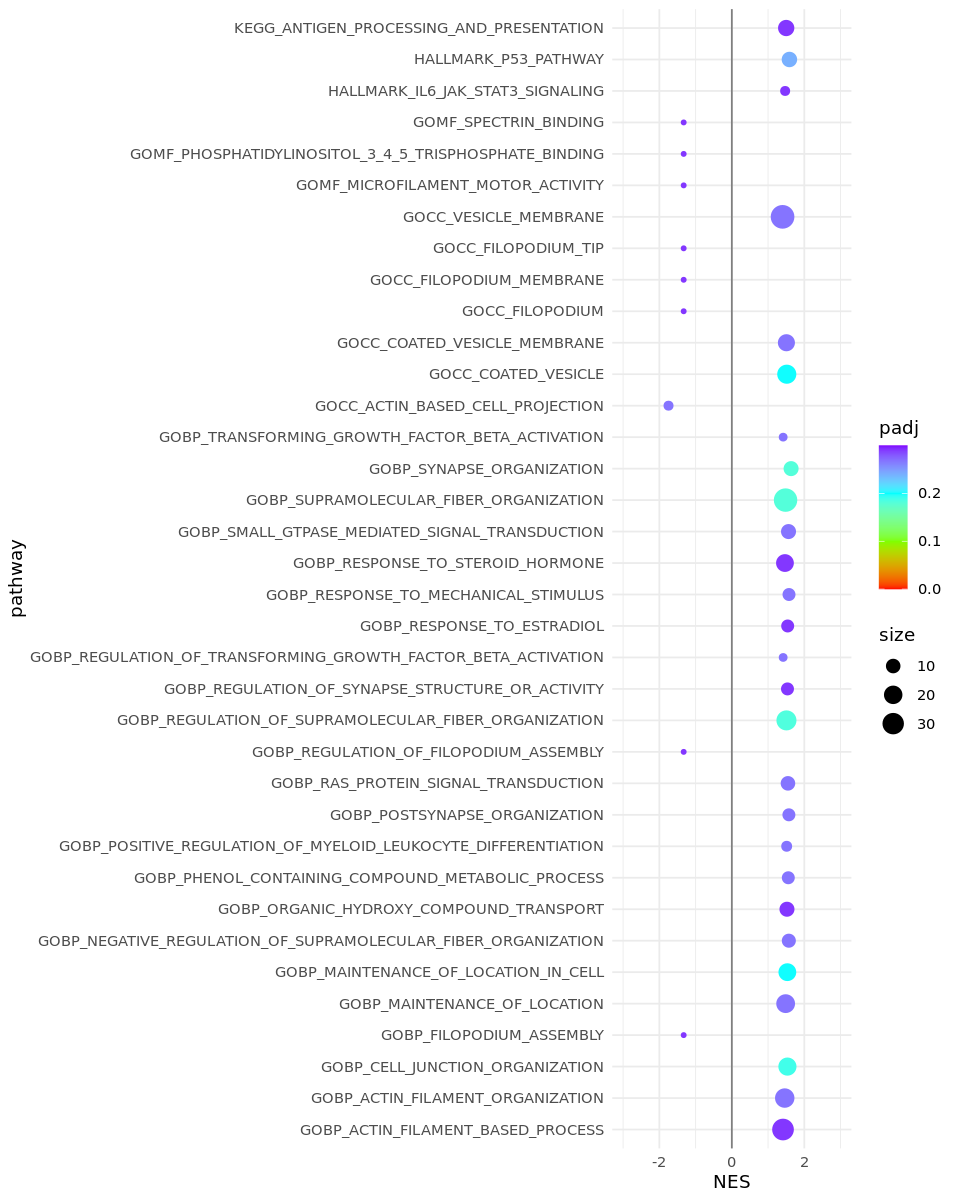

In [67]:

options(repr.plot.width=8, repr.plot.height=10)

p <- ggplot(selected_sc_fgseaRes, aes(NES, pathway))
p + geom_point(aes(colour=padj, size=size)) +
    scale_color_gradientn(colours=rainbow(4), limits=c(0, padj.cutoff)) +
    geom_vline(xintercept=0, size=0.5, colour="gray50") +
    theme_minimal() +
#     theme(text = element_text(size = 15),    
#           axis.text.y = element_text(colour = selected_sc_fgseaRes$color)) +
    expand_limits(x=c(-3,3)) 
    scale_x_continuous(breaks=c(-3,-2,-1,0,1,2,3)) 

In [17]:
topPathways <- c('KEGG_LYSOSOME','GOMF_RNA_BINDING')


## heatmap genes of top pathways

In [172]:
PoI <- 'GOBP_VASCULATURE_DEVELOPMENT'

In [173]:
pathwayGenes <- sc_fgseaResTidy %>%
    filter( pathway == PoI) %>% 
    select(pathway,leadingEdge) %>% column_to_rownames('pathway')

In [174]:
logFC <- preOn_res %>% filter(gene %in% pathwayGenes[PoI,][[1]]) %>% 
    select(logFC_condition, gene) %>% 
#     column_to_rownames('gene') %>% 
# mutate(logFC_condition_ = logFC_condition) %>%
    arrange(logFC_condition)
logFC$gene <- factor(logFC$gene, levels = logFC$gene)

In [175]:
logFC

logFC_condition,gene
<dbl>,<fct>
-1.7275649,BSG
-1.4297459,KLF2
-1.1689440,PTPRB
-1.0985270,NRP1
-1.0618215,COL4A2
-1.0587901,KLF4
-1.0220940,HSPG2
-0.8943975,ROBO4
-0.8751609,SPARC


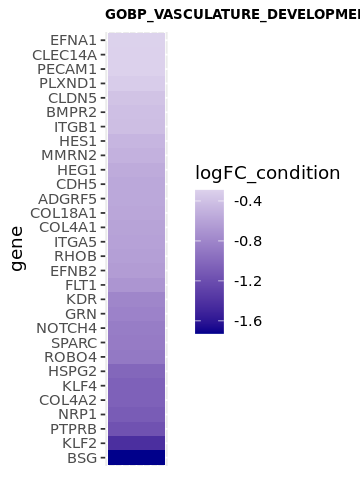

In [176]:
options(repr.plot.width=3, repr.plot.height=4)

ggplot(logFC, aes(x = 1,y = gene, fill = logFC_condition)) + 
  geom_tile() +   
scale_fill_gradient2(low="darkblue", high="firebrick2", guide="colorbar")+
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
         plot.title = element_text(size = 8, face = "bold")) +
ggtitle(PoI) 

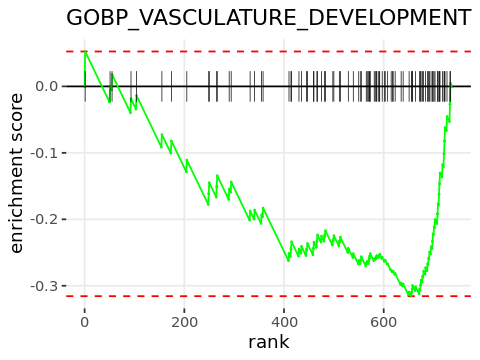

In [177]:
options(repr.plot.width=4, repr.plot.height=3)

plotEnrichment(c(pathways.GO, pathways.hallmark, pathways.KEGG)[[PoI]],
               sc_ranks) + labs(title=PoI)